In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder

import numpy as np
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import copy
import xgboost as xgb
from sklearn.model_selection import cross_validate
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
def get_new_col(df, new_col):
  cal_train = df.copy(deep=True)
  for i in new_col:
      split_col = i.split('*')
      if len(split_col) >= 2:
          col_name = ""
          for j in range(len(split_col)):
              if j == 0:
                  col_name = split_col[j]
                  cal_train['cal'] = cal_train[split_col[j]]
              else:
                  col_name += f'*{split_col[j]}'
                  cal_train['cal'] *= cal_train[split_col[j]]
          df[col_name] = cal_train['cal']
  return df

In [3]:
def get_data(data_list):
    copy_data_list = copy.deepcopy(data_list)
    new_data = ""
    for i in range(len(copy_data_list)):
        if i == 0:
            new_data = copy_data_list[i]
        else:
            new_data = pd.concat([new_data, copy_data_list[i]])
    del_list = []
    for i in new_data.columns:
        if '남은시간' in i:
            del_list.append(i)
    new_data = new_data.drop(del_list, axis=1)
    return new_data

In [4]:
def test_(df):
    test_train = df.copy(deep=True)
    test_train['풍속'] = np.log1p(test_train['풍속'])

    y_train = test_train['풍속']
    X = test_train.drop(['풍속'],axis=1)
    X_col = X.columns
    scaler = StandardScaler()
    scaler.fit(X)
    scaled_X_train  = scaler.transform(X)
    scaled_X_train  = pd.DataFrame(scaled_X_train , columns=X_col)

    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', max_depth=5)
    nmse = cross_validate(xg_reg, scaled_X_train, y_train,
                      scoring=['neg_mean_squared_error'],
                      return_train_score=True,
                      cv=5, n_jobs=-1)
    mse = -1 * nmse['test_neg_mean_squared_error']
    rmse = np.sqrt(mse)
    avg_rmse = round(np.mean(rmse),4)
    print(f"평균 RMSE :{avg_rmse :.4f}")
    return avg_rmse

In [37]:
# train.csv 파일 불러오기
train_data = pd.read_csv('train.csv')

new_columns = {
    '섭씨 온도(°⁣C)': '섭씨온도',
    '절대 온도(K)': '절대온도',
    '이슬점 온도(°C)': '이슬점온도',
    '상대 습도 (%)': '상대습도',
    '대기압(mbar)': '대기압',
    '포화 증기압(mbar)': '포화증기압',
    '실제 증기압(mbar)': '실제증기압',
    '증기압 부족량(mbar)': '증기압부족량',
    '수증기 함량 (g/kg)': '수증기함량',
    '공기 밀도 (g/m**3)': '공기밀도',
    '풍향 (deg)': '풍향',
    '풍속 (m/s)': '풍속'
}

# 열 이름 변경 적용
train_data.rename(columns=new_columns, inplace=True)
# 결측치를 평균값으로 대체
train_data = train_data.fillna(train_data.mean())

# '측정 시간대'를 원핫 인코딩하여 숫자 형태로 변환
encoder = OneHotEncoder(sparse=False)
time_encoded = encoder.fit_transform(train_data[['측정 시간대']])
time_encoded_df = pd.DataFrame(time_encoded, columns=encoder.get_feature_names(['측정 시간대']))
train_data = pd.concat([train_data, time_encoded_df], axis=1).drop(['측정 시간대','ID','월','일'], axis=1)
train_data

C:\Users\user\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
C:\Users\user\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,섭씨온도,절대온도,이슬점온도,상대습도,대기압,포화증기압,실제증기압,증기압부족량,수증기함량,공기밀도,풍향,풍속,측정 시간대_새벽,측정 시간대_오전,측정 시간대_오후,측정 시간대_저녁
0,13.97,287.78,9.84,76.10,992.08,15.98,12.16,3.82,7.66,1198.06,155.60,1.61,0.0,0.0,0.0,1.0
1,16.94,290.85,12.14,73.30,991.07,19.33,14.17,5.16,8.94,1183.67,177.00,1.68,0.0,1.0,0.0,0.0
2,9.76,283.84,5.40,74.20,988.71,12.10,8.98,3.12,5.67,1213.22,146.20,0.73,0.0,0.0,0.0,1.0
3,5.27,277.30,2.71,83.50,1014.25,8.89,7.43,1.47,4.57,1265.48,264.50,2.71,0.0,1.0,0.0,0.0
4,17.35,290.86,12.68,74.00,995.77,19.84,14.68,5.16,9.22,1187.40,19.34,1.00,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36576,14.10,287.79,4.99,54.15,993.53,16.11,8.73,7.39,5.48,1200.85,292.90,0.77,0.0,0.0,0.0,1.0
36577,3.80,277.91,-1.01,70.70,988.03,8.02,5.67,2.35,3.58,1240.06,210.50,8.97,0.0,1.0,0.0,0.0
36578,20.06,295.10,16.70,81.00,977.90,23.51,19.04,4.47,12.20,1153.24,19.22,2.58,0.0,0.0,0.0,1.0
36579,25.65,299.81,15.30,52.81,988.39,32.98,17.41,15.56,11.03,1144.61,225.40,0.36,0.0,0.0,0.0,1.0


In [38]:
#test_(train_data)

C:\Users\user\anaconda3\envs\tf\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 49453 (\N{HANGUL SYLLABLE SEOB}) missing from current font.
  fig.canvas.draw()
C:\Users\user\anaconda3\envs\tf\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 50472 (\N{HANGUL SYLLABLE SSI}) missing from current font.
  fig.canvas.draw()
C:\Users\user\anaconda3\envs\tf\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from current font.
  fig.canvas.draw()
C:\Users\user\anaconda3\envs\tf\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.draw()
C:\Users\user\anaconda3\envs\tf\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 51208 (\N{HANGUL SYLLABLE JEOL}) missing from current font.
  fig.canvas.draw()
C:\Users\user\anaconda3\envs\tf\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.

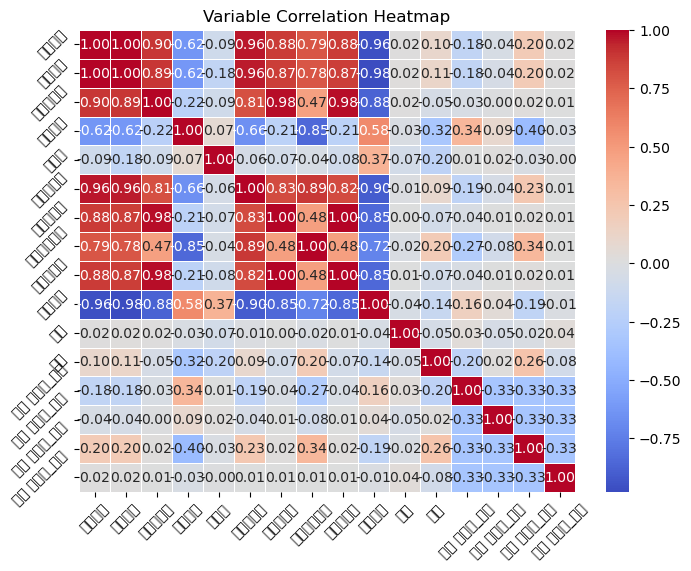

In [39]:
# 변수간 상관관계 계산
correlation_matrix = train_data.corr()
# 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Variable Correlation Heatmap')
plt.xticks(rotation=45)  # x축 레이블 회전
plt.yticks(rotation=45)  # y축 레이블 회전
plt.show()

1. 섭씨온도, 절대온도, 이슬점 온도
절대온도
이슬점온도
포화 증기압
실제 증기압
증기압 부족량
수증기함량

2. 상대습도
공기밀도

3. 실제증기압
수증기함량

4. 공기밀도
대기압


In [44]:
# 풍속을 예측할 특성(입력 변수)과 풍속(출력 변수)을 분리합니다.
X_train = train_data.drop(['풍속'], axis=1)  # 입력 변수들
y_train = train_data['풍속']  # 출력 변수 (풍속)

train_data.columns

Index(['섭씨온도', '절대온도', '이슬점온도', '포화증기압', '실제증기압', '증기압부족량', '수증기함량', '풍향',
       '풍속', '섭씨온도*절대온도*이슬점온도*포화증기압', '섭씨온도*절대온도*이슬점온도*실제증기압',
       '섭씨온도*절대온도*이슬점온도*증기압부족량', '섭씨온도*절대온도*이슬점온도*수증기함량', '실제증기압*수증기함량'],
      dtype='object')

In [30]:
# test.csv 파일 불러오기
test_data = pd.read_csv('test.csv')
# 열 이름 변경 적용
new_columns = {
    '섭씨 온도(°⁣C)': '섭씨온도',
    '절대 온도(K)': '절대온도',
    '이슬점 온도(°C)': '이슬점온도',
    '상대 습도 (%)': '상대습도',
    '대기압(mbar)': '대기압',
    '포화 증기압(mbar)': '포화증기압',
    '실제 증기압(mbar)': '실제증기압',
    '증기압 부족량(mbar)': '증기압부족량',
    '수증기 함량 (g/kg)': '수증기함량',
    '공기 밀도 (g/m**3)': '공기밀도',
    '풍향 (deg)': '풍향',
    '풍속 (m/s)': '풍속'
}

test_data.rename(columns=new_columns, inplace=True)

# 결측치를 평균값으로 대체
test_data = test_data.fillna(test_data.mean())

# '측정 시간대'를 원핫 인코딩하여 숫자 형태로 변환
time_encoded = encoder.transform(test_data[['측정 시간대']])
time_encoded_df = pd.DataFrame(time_encoded, columns=encoder.get_feature_names(['측정 시간대']))
test_data = pd.concat([test_data, time_encoded_df], axis=1).drop(['측정 시간대','ID','월','일'], axis=1)  

'''
test_list = []
col_list = []
for case in tqdm(range(1, 59)):
    if case < 10:
        case = '0'+str(case)
    particular_case = test_data.interpolate()
    group_ = particular_case.reset_index()
    group_ = group_.drop(['ID', '월', '일', 'index'], axis=1)
    test_list.append(group_)

test_data = get_data(test_list)
test_data

'''
test_data = test_data.drop(['상대습도', '대기압', '공기밀도', '측정 시간대_새벽', '측정 시간대_오전', '측정 시간대_오후', '측정 시간대_저녁'], axis=1)
test_data

C:\Users\user\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
C:\Users\user\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,섭씨온도,절대온도,이슬점온도,포화증기압,실제증기압,증기압부족량,수증기함량,풍향
0,4.28,278.68,-0.21,8.30,6.02,2.28,3.81,251.80
1,13.40,286.81,10.36,15.40,12.59,2.80,7.89,225.60
2,19.89,294.33,14.95,23.26,17.03,6.23,10.82,10.39
3,-2.88,270.44,-4.47,4.94,4.38,0.56,2.73,260.20
4,6.97,281.18,4.36,10.01,8.35,1.66,5.28,262.50
...,...,...,...,...,...,...,...,...
15673,1.61,274.67,-0.49,6.86,5.89,0.97,3.67,56.18
15674,18.27,292.19,13.35,21.03,15.35,5.68,9.69,265.30
15675,16.08,289.66,12.25,18.30,14.28,4.03,8.97,189.80
15676,3.07,276.68,-0.95,7.62,5.70,1.92,3.57,269.70


In [45]:
# XGBoost 모델을 초기화합니다.
xg_reg = xgb.XGBRegressor(objective='reg:squarederror')

# 하이퍼파라미터 후보들을 설정합니다.
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.01, 0.001]
}

# GridSearchCV를 이용하여 하이퍼파라미터 튜닝을 수행합니다.
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터를 출력합니다.
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}


In [46]:
# 스케일링을 위해 StandardScaler를 사용합니다.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
# 랜덤 포레스트 모델과 XGBoost 모델을 초기화합니다.
rf_model = RandomForestRegressor(random_state=42)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=5)

# 스태킹을 수행할 StackingRegressor를 초기화합니다.
stacked_model = StackingRegressor(
    estimators=[('rf', rf_model), ('xgb', xgb_model)],
    final_estimator=xgb.XGBRegressor(objective='reg:squarederror', max_depth=5)
)

# 스태킹 모델을 학습시킵니다.
stacked_model.fit(X_train_scaled, y_train)

# 테스트 데이터로 풍속 예측을 수행합니다.
y_pred_stacked = stacked_model.predict(X_test_scaled)

In [16]:
'''
# 랜덤 포레스트 회귀 모델을 사용하여 풍속 예측 모델을 학습시킵니다.
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# 테스트 데이터로 풍속 예측을 수행합니다.
X_test = test_data  # 테스트 입력 변수들
y_pred = model.predict(X_test)  # 테스트 데이터로 풍속 예측
'''

In [17]:
# Submit / 제출
submission = pd.read_csv('./sample_submission.csv')
submission['풍속 (m/s)'] = y_pred_stacked

# 예측 결과를 submission.csv 양식에 맞게 저장합니다.
submission.to_csv('submission.csv', index=  False)

print("풍속 예측이 완료되었습니다. 결과가 submission.csv에 저장되었습니다.")

풍속 예측이 완료되었습니다. 결과가 submission.csv에 저장되었습니다.


NameError: name 'model' is not defined